In [1]:
import numpy as np
from datetime import datetime

csv_file = "Stage.Working@08MH028.20110101_corrected.csv"
skip_rows = 15  # header line

# Read all lines after header
with open(csv_file, 'r') as f:
    lines = f.readlines()[skip_rows:]

# Keep only lines with at least 3 columns
data_lines = [line.strip().split(',') for line in lines if len(line.strip().split(',')) >= 3]

# Convert timestamps and stage values
stages = np.array([
    [datetime.strptime(row[0], "%Y-%m-%dT%H:%M:%SZ"), float(row[2])]
    for row in data_lines
])

# Filter for 2023-01-01 to 2024-12-31
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31, 23, 59, 59)

mask = (stages[:, 0] >= start_date) & (stages[:, 0] <= end_date)
stages = np.array(stages)[mask]

print("Loaded", len(stages), "rows")
print(stages.shape)


Loaded 209661 rows


In [20]:
stages[0][0], stages[0][1]

(datetime.datetime(2023, 1, 1, 0, 0), 3.01190610530716)

In [21]:
timestamps = np.load("processed-data/timestamps.npz", allow_pickle=True)['timestamps']
timestamps.shape


(17535,)

In [43]:
import numpy as np

# Convert datetime objects to UNIX timestamps (seconds)
timestamps_unix = np.array([t.timestamp() for t in timestamps])
stage_times_unix = np.array([t.timestamp() for t in stages[:, 0]])

idx = np.searchsorted(stage_times_unix, timestamps_unix)
idx = np.clip(idx, 1, len(stage_times_unix)-1)

# Compare distances to previous entry — pick whichever is closer
prev = stage_times_unix[idx-1]
next = stage_times_unix[idx]
idx_closest = np.where(
    np.abs(timestamps_unix - prev) < np.abs(timestamps_unix - next),
    idx-1, idx
)

# Extract corresponding values
stages_aligned = stages[idx_closest, 1].astype(float)

print(stages_aligned.shape)
print(stages_aligned[:10])


(17535,)
[3.01190611 2.4149143  1.88892249 1.53093069 1.41493888 1.58394707
 1.92995527 2.38696346 2.84697165 3.19897985]


In [63]:
import os

np.savez_compressed(os.path.join("./processed-data/", 'river_heights.npz'), river_heights=stages_aligned)

In [78]:
stages_aligned.shape

(17535,)

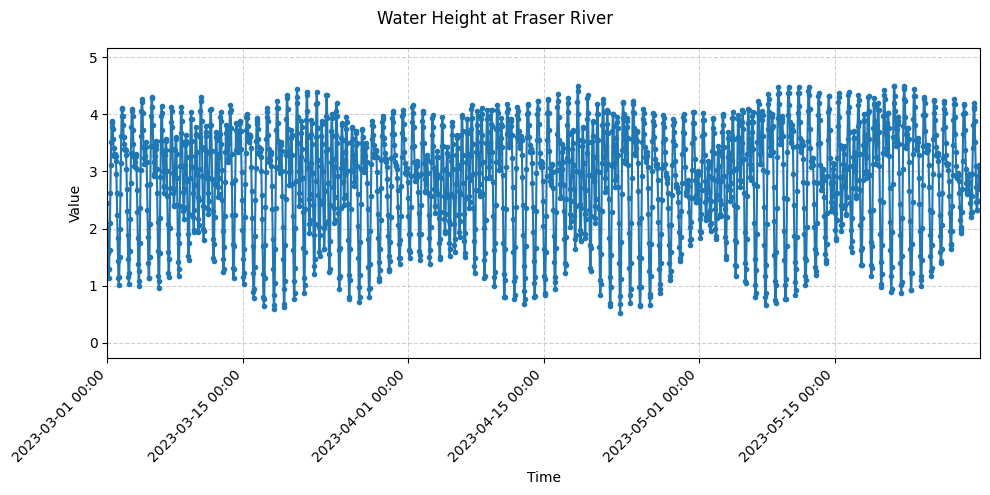

In [75]:
from plot_utils import plot_timeseries

plot_timeseries(timestamps, stages_aligned,
                start=datetime(2023, 3, 1),
                end=datetime(2023, 5, 30),
                title="Water Height at Fraser River",)


Top dominant frequencies and periods:
  Frequency = 0.00011 1/hr → Period ≈ 8767.5 hr (365.31 days)
  Frequency = 0.00023 1/hr → Period ≈ 4383.8 hr (182.66 days)
  Frequency = 0.03724 1/hr → Period ≈ 26.9 hr (1.12 days)
  Frequency = 0.03855 1/hr → Period ≈ 25.9 hr (1.08 days)
  Frequency = 0.03872 1/hr → Period ≈ 25.8 hr (1.08 days)
  Frequency = 0.03889 1/hr → Period ≈ 25.7 hr (1.07 days)
  Frequency = 0.03901 1/hr → Period ≈ 25.6 hr (1.07 days)
  Frequency = 0.03912 1/hr → Period ≈ 25.6 hr (1.07 days)
  Frequency = 0.04117 1/hr → Period ≈ 24.3 hr (1.01 days)
  Frequency = 0.04129 1/hr → Period ≈ 24.2 hr (1.01 days)
  Frequency = 0.04146 1/hr → Period ≈ 24.1 hr (1.00 days)
  Frequency = 0.04157 1/hr → Period ≈ 24.1 hr (1.00 days)
  Frequency = 0.04169 1/hr → Period ≈ 24.0 hr (1.00 days)
  Frequency = 0.04180 1/hr → Period ≈ 23.9 hr (1.00 days)
  Frequency = 0.04192 1/hr → Period ≈ 23.9 hr (0.99 days)
  Frequency = 0.04209 1/hr → Period ≈ 23.8 hr (0.99 days)
  Frequency = 0.04220 1/hr

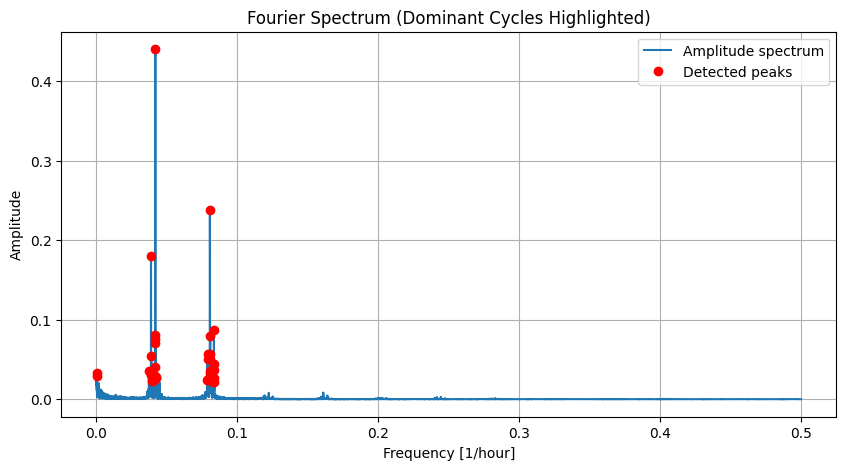

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Assume you already have your data ---
# stages_aligned = np.array([...])
dt = 1.0  # sampling interval in hours
N = len(stages_aligned)

# --- 1. FFT ---
fft_vals = np.fft.fft(stages_aligned - np.mean(stages_aligned))
freqs = np.fft.fftfreq(N, dt)

# --- 2. Keep positive frequencies only ---
pos_mask = freqs > 0
freqs = freqs[pos_mask]
amplitude = np.abs(fft_vals[pos_mask]) / N

# --- 3. Find peaks in amplitude spectrum ---
peaks, _ = find_peaks(amplitude, height=np.max(amplitude)*0.05)  # keep strong peaks
dominant_freqs = freqs[peaks]
dominant_periods_hours = 1 / dominant_freqs
dominant_periods_days = dominant_periods_hours / 24

# --- 4. Print results ---
print("Top dominant frequencies and periods:")
for f, p_h, p_d in sorted(zip(dominant_freqs, dominant_periods_hours, dominant_periods_days),
                          key=lambda x: x[0]):
    print(f"  Frequency = {f:.5f} 1/hr → Period ≈ {p_h:.1f} hr ({p_d:.2f} days)")

# --- 5. Plot amplitude spectrum with peaks ---
plt.figure(figsize=(10,5))
plt.plot(freqs, amplitude, label="Amplitude spectrum")
plt.plot(dominant_freqs, amplitude[peaks], "ro", label="Detected peaks")
plt.xlabel("Frequency [1/hour]")
plt.ylabel("Amplitude")
plt.title("Fourier Spectrum (Dominant Cycles Highlighted)")
plt.legend()
plt.grid(True)
plt.show()

